# **Transfer Learning for Classification Using Pretrained VGG16 Model**
#### **Introduction**

In this project, we will classify aircraft damage using a pre-trained VGG16 model.

#### **Project Overview**

This project aims to automate the classification of aircraft damage into two categories: "dent" and "crack." For this, we will utilize feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images.

#### **Final Output**
A trained model capable of classifying aircraft images into "dent" and "crack" categories, enabling automated aircraft damage detection.

## Setup

#### Suppress the tensorflow warning message

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Import Libraries

In [ ]:
# import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# Set the batch size, epochs, and input_shape
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

#### Extract the Dataset: Unzip the dataset to the current directory, creating directories for training, testing, and validation splits.

In [4]:
import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")
    
    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")


Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
The folder 'aircraft_damage_dataset_v1' already exists. Removing the existing folder.
Removed the existing folder: aircraft_damage_dataset_v1
Extracted aircraft_damage_dataset_v1.tar successfully.


The folder structure looks as follows:

```python
aircraft_damage_dataset_v1/
├── train/
│   ├── dent/
│   └── crack/
├── valid/
│   ├── dent/
│   └── crack/
└── test/
    ├── dent/
    └── crack/

```


In [5]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

## Data Preprocessing
Create data generators for training, validation, and testing datasets.

First,we will create ImageDataGenerators used for training, validation and testing. The ImageDataGenerator class is part of Keras. It is a powerful utility for real-time image data augmentation, preprocessing, and feeding data into deep learning models during training. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset to improve model generalization.

We will create instances of the ImageDataGenerator class. Each instance corresponds to one of the datasets: training, validation, and testing.

In [6]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Next, we use flow_from_directory() method to load the images from directory and generate the training, validation, and testing datasets. The flow_from_directory() method is part of the ImageDataGenerator class in Keras, and it plays a crucial role in automating the process of loading, preprocessing, and batching images for training, validation, and testing. We use the _datagen object to load and preprocess the images. Specifically, the flow_from_directory() function is used to read images directly from the directory and generate batches of data that will be fed into the model.

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

valid_generator =  valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_rows, img_cols)
)
test_generator =  valid_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_rows, img_cols)
)

Found 300 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Model Definition

Load the pre-trained model VGG16

In [8]:
weights='imagenet' # Load the pretrained weights from training on the ImageNet dataset
include_top=False # Exclude final fully connected layers for transfer learning
input_shape=(img_rows, img_cols, 3)

base_model = VGG16(weights= weights, include_top= include_top, input_shape=input_shape)

Now, we modify the VGG16 model for our specific classification task. We extract the output from the last convolutional layer of the pre-trained VGG16 model and flatten it, and then create a new model by adding our custom layers. We will freeze the base VGG16 model layers so that their weights will not be updated during training.

In [9]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. This involves adding fully connected layers (Dense), activation functions (ReLU), and Dropout layers to avoid overfitting. Here, we are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").

In [10]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

Compile the model

In [11]:
loss= 'binary_crossentropy'
optimizer =Adam(learning_rate=0.0001)
metrics= ['accuracy']

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

Model Training

In [12]:
history = model.fit(
    train_generator,
    epochs=n_epochs, 
    validation_data=valid_generator,
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5192 - loss: 0.7190 - val_accuracy: 0.6042 - val_loss: 0.6338
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7010 - loss: 0.5582 - val_accuracy: 0.6979 - val_loss: 0.5821
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7865 - loss: 0.4846 - val_accuracy: 0.7188 - val_loss: 0.5486
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8258 - loss: 0.3879 - val_accuracy: 0.6562 - val_loss: 0.6457
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8663 - loss: 0.3421 - val_accuracy: 0.7083 - val_loss: 0.5098


## Visualizing Results

Plot loss and accuracy curves for training and validation sets

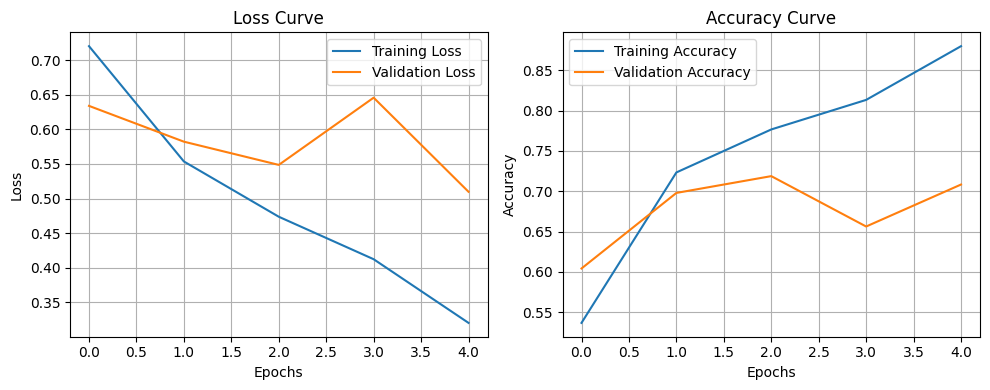

In [22]:
# Access the training history
train_history = model.history.history  # After training

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 2 rows, 1 column

# Plot Loss
ax1.plot(train_history['loss'], label='Training Loss')
ax1.plot(train_history['val_loss'], label='Validation Loss')
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(train_history['accuracy'], label='Training Accuracy')
ax2.plot(train_history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

Model Evaluation

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7812 - loss: 0.6039
Test Loss: 0.6039
Test Accuracy: 0.7812


## Predictions

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, true_label, predicted_label, class_names):
    plt.imshow(image)
    true_label_name = class_names[true_label]
    pred_label_name = class_names[predicted_label]
    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')

# Function to test the model and plot 5 images
def test_model_on_images(test_generator, model, num_images=5):
    # Get a batch of images and labels
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get class name mapping
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}

    # Plot the first `num_images` images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plot_image_with_title(
            image=test_images[i],
            true_label=int(test_labels[i]),
            predicted_label=predicted_classes[i],
            class_names=class_names
        )
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


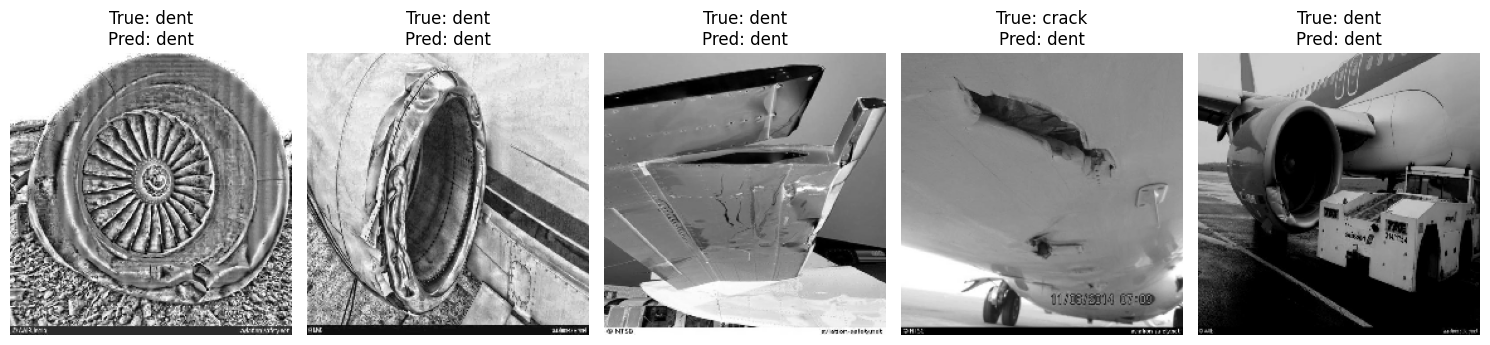

In [26]:
test_model_on_images(test_generator, model, num_images=5)